In [1]:
pip install librosa


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import csv

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

#load csv

In [3]:
metadata = pd.read_csv('/Users/91954/ my project/filtered_dataset.csv')  # Read csv file 
metadata.head(3)

,File_Id,Genus,Species,English_Name,Country,Location,Latitude,Longitude,Altitude,Type,Filename
0,363142,Melospiza,melodia,Song Sparrow,United States,"Yampa River Botanic Park, Routt Co, Colorado",40.4725,-106.8311,2100,song,363142-0.wav
1,490351,Melospiza,melodia,Song Sparrow,United States,"Hawk Rise Sanctuary (near Linden), Union Coun...",40.6052,-74.2495,0,song,490351-10.wav
2,551290,Melospiza,melodia,Song Sparrow,United States,"Rahway, Union County, New Jersey",40.6061,-74.2772,10,song,551290-10.wav


In [4]:
metadata.shape

(2500, 11)

In [5]:
metadata['Species'].value_counts()

Species
melodia        500
polyglottos    500
cardinalis     500
migratorius    500
bewickii       500
Name: count, dtype: int64

In [6]:
has_duplicates = metadata['Filename'].duplicated().any()
has_duplicates

False

In [7]:
metadata.isnull().sum()

File_Id          0
Genus            0
Species          0
English_Name     0
Country          0
Location         0
Latitude        38
Longitude       38
Altitude        14
Type             0
Filename         0
dtype: int64

#Audio feature extraction

In [8]:
# Create the dictionary
name_dict = dict(zip(metadata['Filename'], metadata['Species']))
name_dict

{'363142-0.wav': 'melodia',
 '490351-10.wav': 'melodia',
 '551290-10.wav': 'melodia',
 '549591-9.wav': 'melodia',
 '105818-11.wav': 'melodia',
 '366598-2.wav': 'melodia',
 '111653-9.wav': 'melodia',
 '288000-8.wav': 'melodia',
 '62782-2.wav': 'melodia',
 '111666-4.wav': 'melodia',
 '368065-5.wav': 'melodia',
 '111654-1.wav': 'melodia',
 '469877-5.wav': 'melodia',
 '128904-4.wav': 'melodia',
 '111653-6.wav': 'melodia',
 '393994-2.wav': 'melodia',
 '111671-1.wav': 'melodia',
 '269172-2.wav': 'melodia',
 '381570-5.wav': 'melodia',
 '142619-7.wav': 'melodia',
 '111644-7.wav': 'melodia',
 '246812-3.wav': 'melodia',
 '462899-1.wav': 'melodia',
 '111653-2.wav': 'melodia',
 '111654-11.wav': 'melodia',
 '105818-5.wav': 'melodia',
 '149420-9.wav': 'melodia',
 '425799-10.wav': 'melodia',
 '327795-8.wav': 'melodia',
 '551290-2.wav': 'melodia',
 '111654-0.wav': 'melodia',
 '408018-0.wav': 'melodia',
 '125723-5.wav': 'melodia',
 '189286-1.wav': 'melodia',
 '125718-4.wav': 'melodia',
 '306748-13.wav'

In [9]:
# Define the directory containing audio files
audio_dir = '/Users/91954/ my project/wavfiles'

# os.listdir() to get filenames
filenames = os.listdir(audio_dir)

# Create audio paths by combining directory and filenames
audio_paths = [os.path.join(audio_dir, filename) for filename in filenames]

#Feature extraction

In [10]:
mel, mfcc = [], []
spectral_centroid, rms, bandwidth, chromagram = [], [], [], []
filename, labels = [], []

for path in audio_paths:
    file = os.path.basename(path)  # Extract filename from UR
    
    if file in name_dict:
        # Load audio file
        y, sr = librosa.load(path)
        filename.append(file)
        labels.append(name_dict[file])
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mels=20, n_mfcc=130)
        mfcc.append(mfccs.T)
    
        # Extract mel-spectrogram
        melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20, htk=True, fmin=1400)
        S = librosa.power_to_db(melspectrogram)
        mel.append(S.T)

        # spectral centroid
        spectral_centroid.append((librosa.feature.spectral_centroid(y=y, sr=sr)).T)
        
        # bandwidth
        bandwidth.append((librosa.feature.spectral_bandwidth(y=y, sr=sr)).T)
        
        #Extract root mean square(rms)for analyzing the energy content of audio signals
        rms.append((librosa.feature.rms(y=y)).T)  
        

In [11]:
# Convert audio_labels to dataframe
audio_labels = pd.DataFrame(labels, columns=['Species'])
audio_labels['Filename'] = filename
audio_labels.head(5)

,Species,Filename
0,melodia,102948-0.wav
1,migratorius,103059-0.wav
2,migratorius,103059-10.wav
3,migratorius,103059-11.wav
4,migratorius,103059-12.wav


In [12]:
print('Shape of mfcc :', np.array(mfcc).shape)
print('Shape of mel-spectrogram :', np.array(mel).shape)
print('Shape of spectral_centroid :', np.array(spectral_centroid).shape)
print('Shape of rms :', np.array(rms).shape)
print('Shape of bandwidth :', np.array(bandwidth).shape)
print('Shape of chromagram :', np.array(chromagram).shape)

Shape of mfcc : (2500, 130, 20)
Shape of mel-spectrogram : (2500, 130, 20)
Shape of spectral_centroid : (2500, 130, 1)
Shape of rms : (2500, 130, 1)
Shape of bandwidth : (2500, 130, 1)
Shape of chromagram : (0,)


#Scale data

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# Create a StandardScaler object
scaler = StandardScaler()

def scale(data):

    if len(data.shape) == 2:
         
        scaler.fit(data)  # Fit the scaler
        data = scaler.transform(data)  # Scale data using the fitted scaler
        return data, scaler.mean_, scaler.scale_

    elif len(data.shape) == 3:

        batch, n_row, n_col = data.shape
        data_reshape = data.reshape(-1, n_row * n_col)  # flatten the np arrays to 1D
        
        scaler.fit(data_reshape)      # Fit the scaler
        data_scaled = scaler.transform(data_reshape)  # Scale data using the fitted scaler
        
        data = data_scaled.reshape(-1, n_row, n_col)  # reshape the data to the original shape
        return data, scaler.mean_, scaler.scale_
    
    else:
        raise ValueError("Input array must be 2D or 3D.")



def processed(data, mean=False):
    
    data = np.array(data)
    
    if mean:
        data = np.mean(data, axis=1)
        return scale(data)
    else:
        return scale(data)
  

#Encode data

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
#Label Encoder
le = LabelEncoder()

audio_labels['Encoded'] = le.fit_transform(labels)
audio_labels.head(5)

,Species,Filename,Encoded
0,melodia,102948-0.wav,2
1,migratorius,103059-0.wav,3
2,migratorius,103059-10.wav,3
3,migratorius,103059-11.wav,3
4,migratorius,103059-12.wav,3


In [17]:
# Create a dictionary with encoded labels as key and species as values
class_label = dict(zip(audio_labels['Encoded'],audio_labels['Species']))
class_label

{2: 'melodia',
 3: 'migratorius',
 0: 'bewickii',
 1: 'cardinalis',
 4: 'polyglottos'}

In [18]:
# Sort the dictionary by key in ascending order
sorted_class_labels = dict(sorted(class_label.items()))

# Extract a list of values (bird species)
class_labels = list(sorted_class_labels.values())

class_labels

['bewickii', 'cardinalis', 'melodia', 'migratorius', 'polyglottos']

#Split data

mfcc, bandwidth, spectral centroid, rms are calculated

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Combine all features
all_features = np.concatenate((np.array(mfcc), np.array(bandwidth), np.array(spectral_centroid), np.array(rms)),axis=2)

In [21]:
# calculate scalar mean and stantard deviation
data , mean, std = processed(all_features, mean=True)

In [22]:
# Split the dataset ito features and target variable
X = data
Y = audio_labels['Encoded']

# Split the dataset ito train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

#Cross validation

In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [24]:
# Stratified KFold ensures classes are proportionally distributed in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#KNN classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
def KNN_classifier(n):
    
    # Create the KNN model with n_neighbors (number of neighbors) set to 3
    knn = KNeighborsClassifier(n_neighbors=n)

    # Train the model on the training data
    knn.fit(X_train, Y_train)

    # Make predictions on the testing data
    pred_knn = knn.predict(X_test)

    return pred_knn

In [27]:
val_accuracy = []
neighbors = []

for neighbor in range(1,10):
    
    pred_knn = KNN_classifier(neighbor)  # Make predictions
    
    val_acc = accuracy_score(Y_test,pred_knn)  # Evaluate model accuracy
    val_accuracy.append(val_acc)
    neighbors.append(neighbor)

<Axes: xlabel='Neighbors', ylabel='Values'>

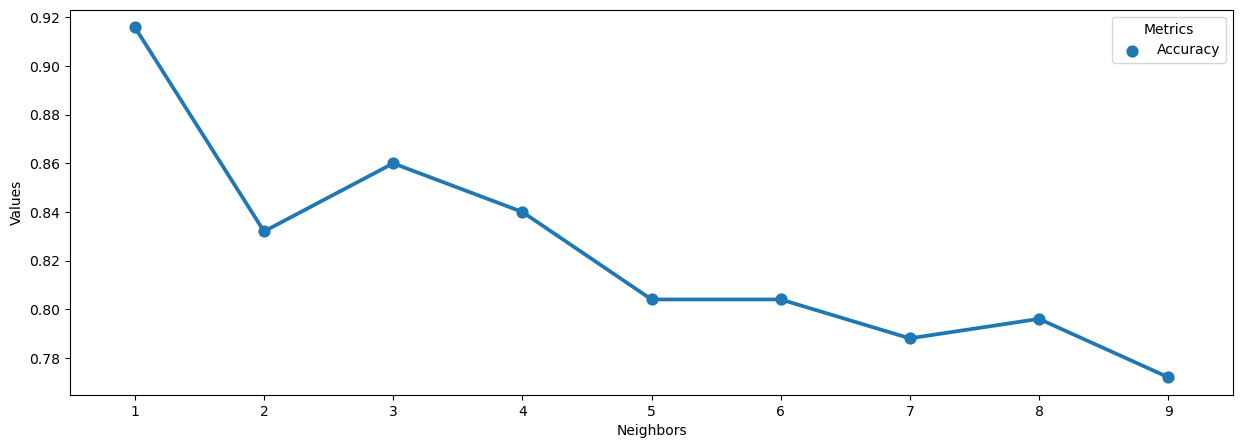

In [28]:
# Tuning n_neighbors for the best accuracy
Tuning_neighbors = {'Accuracy':val_accuracy, 'Neighbors':neighbors}
Tuning_neighbors_df = pd.DataFrame.from_dict(Tuning_neighbors)

plot_df = Tuning_neighbors_df.melt('Neighbors', var_name='Metrics', value_name='Values')
fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(x='Neighbors', y='Values', hue='Metrics', data=plot_df, ax=ax)

Cross validation

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)

In [30]:
knn_cv_scores = cross_val_score(knn, X_train, Y_train, cv=cv)
print('cv scores :', knn_cv_scores)
print('Average accuracy :', np.mean(knn_cv_scores))

cv scores : [0.80222222 0.81555556 0.84888889 0.80222222 0.79111111]
Average accuracy : 0.812


#Evaluation

In [31]:
knn_pred = KNN_classifier(3)

# Evaluate model accuracy
knn_accuracy = accuracy_score(Y_test, knn_pred)
print(f'Accuracy : {knn_accuracy:.4f}')

# Calculate f1 score precision and recall
knn_f1 = f1_score(Y_test, knn_pred, average='macro')
knn_precision = precision_score(Y_test, knn_pred, average='weighted')
knn_recall = recall_score(Y_test, knn_pred, average='weighted')

# Print the results
print(f'F1-score : {knn_f1:.4f}')
print(f'Precision : {knn_precision:.4f}')
print(f'Recall : {knn_recall}')

Accuracy : 0.8600
F1-score : 0.8585
Precision : 0.8670
Recall : 0.86


#Classification report

In [32]:
print(classification_report(Y_test, knn_pred, target_names=class_labels))

              precision    recall  f1-score   support

    bewickii       0.80      0.98      0.88        50
  cardinalis       0.82      0.84      0.83        50
     melodia       0.93      0.84      0.88        50
 migratorius       0.85      0.92      0.88        50
 polyglottos       0.92      0.72      0.81        50

    accuracy                           0.86       250
   macro avg       0.87      0.86      0.86       250
weighted avg       0.87      0.86      0.86       250



#Confusion matrix

In [33]:
def confusion_matrix_plot(cm, model):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Purples)
    plt.xticks(rotation=90)  
    plt.title(f'Confusion Matrix ({model})')
    plt.show()

In [34]:
# Generate confusion matrix
knn_confusion_matrix = confusion_matrix(Y_test, knn_pred)

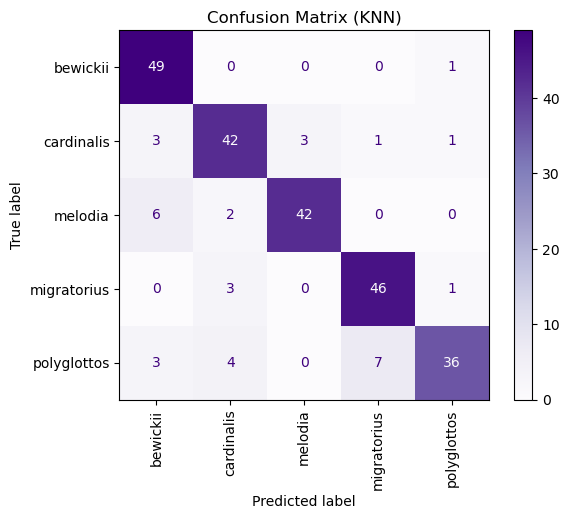

In [35]:
confusion_matrix_plot(knn_confusion_matrix, 'KNN')

#Precision Recall curve

In [36]:
def Precision_Recall_Curve(y_pred, model):
    
    prc_data = {}
    
    for i, class_label in enumerate(class_labels):
        precision, recall, thresholds = precision_recall_curve(Y_test == i, y_pred == i)
        prc_data[class_label] = (precision, recall)
    
    # Plot the precision-recall curves
    plt.figure(figsize=(8, 6))
    for class_label, (precision, recall) in prc_data.items():
        plt.plot(recall, precision, label=class_label)  # Use class_label directly
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({model})')
    plt.legend()
    plt.grid(True)
    plt.show()


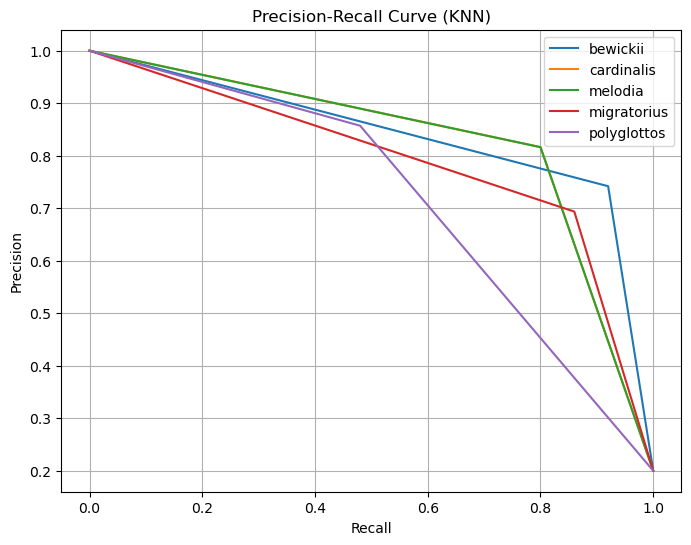

In [37]:
Precision_Recall_Curve(pred_knn, 'KNN')

#Support Vector Algorithm

In [38]:
from sklearn.svm import SVC

In [39]:
svc = SVC(C=1, gamma=0.1)

cross validation

In [40]:
svc_cv_scores = cross_val_score(svc, X_train, Y_train, cv=cv)
print('cv scores :', svc_cv_scores)
print('Average accuracy :', np.mean(svc_cv_scores))

cv scores : [0.84444444 0.86222222 0.88       0.86666667 0.86222222]
Average accuracy : 0.863111111111111


Evaluation

In [41]:
svc.fit(X_train,Y_train)

svc_pred = svc.predict(X_test)

svc_accuracy = accuracy_score(Y_test,svc_pred)
print('Test Accuracy of Support Vector Algorithm: ',svc_accuracy)

# Calculate f1 score precision and recall
svc_f1 = f1_score(Y_test, svc_pred, average='macro')
svc_precision = precision_score(Y_test, svc_pred, average='weighted')
svc_recall = recall_score(Y_test, svc_pred, average='weighted')

# Print the results
print(f'F1-score : {svc_f1:.4f}')
print(f'Precision : {svc_precision:.4f}')
print(f'Recall : {svc_recall}')

Test Accuracy of Support Vector Algorithm:  0.912
F1-score : 0.9123
Precision : 0.9140
Recall : 0.912


Classification Report

In [42]:
print(classification_report(Y_test, svc_pred, target_names=class_labels))

              precision    recall  f1-score   support

    bewickii       0.87      0.94      0.90        50
  cardinalis       1.00      0.94      0.97        50
     melodia       0.90      0.90      0.90        50
 migratorius       0.88      0.92      0.90        50
 polyglottos       0.91      0.86      0.89        50

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



confusion matrix

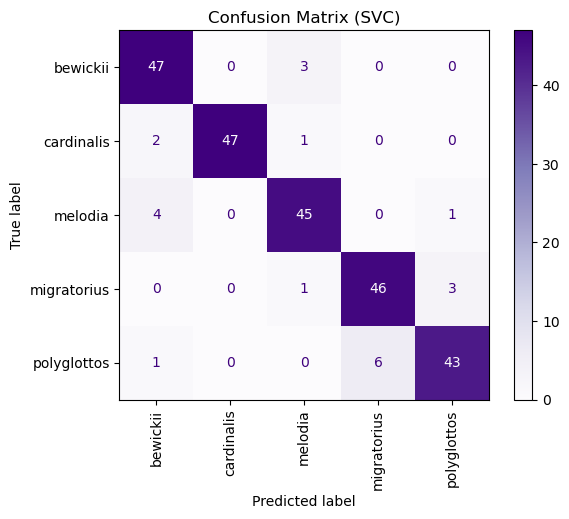

In [43]:
# Generate confusion matrix
svc_confusion_matrix = confusion_matrix(Y_test, svc_pred)
confusion_matrix_plot(svc_confusion_matrix, 'SVC')

Precision Recall Curve

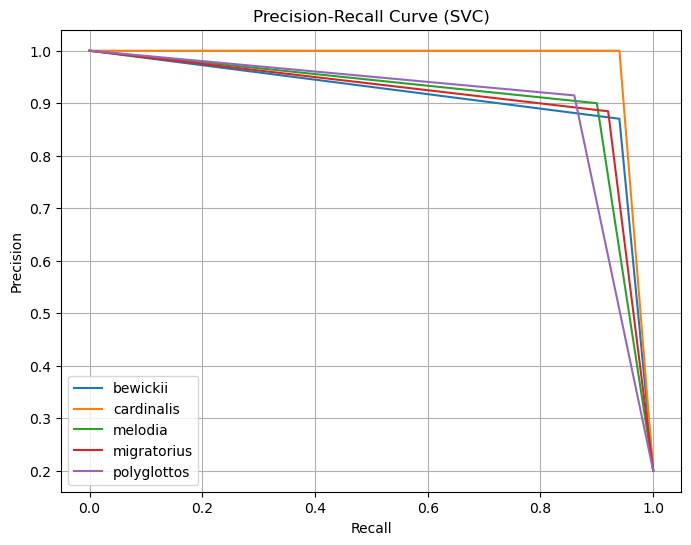

In [44]:
# Precision-recall curve for each bird species
Precision_Recall_Curve(svc_pred, 'SVC')

Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
# Create the Random Forest Classifier model
rfc_model = RandomForestClassifier(n_estimators=300)  # n_estimators (number of trees)

cross validation

In [47]:
rfc_cv_scores = cross_val_score(rfc_model, X_train, Y_train, cv=cv)
print('cv scores :', rfc_cv_scores)
print('Average accuracy :', np.mean(rfc_cv_scores))

cv scores : [0.82       0.82222222 0.83555556 0.84666667 0.80888889]
Average accuracy : 0.8266666666666668


Evaluation

In [48]:
# Train the model
rfc_model.fit(X_train, Y_train)

# Make predictions on the testing set
rfc_pred = rfc_model.predict(X_test)

# Evaluate the model's accuracy
rfc_accuracy = accuracy_score(Y_test, rfc_pred)
print("Accuracy:", rfc_accuracy)

# Calculate f1 score precision and recall
rfc_f1 = f1_score(Y_test, rfc_pred, average='macro')
rfc_precision = precision_score(Y_test, rfc_pred, average='weighted')
rfc_recall = recall_score(Y_test, rfc_pred, average='weighted')

# Print the results
print(f'F1-score : {rfc_f1:.4f}')
print(f'Precision : {rfc_precision:.4f}')
print(f'Recall : {rfc_recall}')

Accuracy: 0.904
F1-score : 0.9037
Precision : 0.9048
Recall : 0.904


Classification Report

In [49]:
print(classification_report(Y_test, rfc_pred, target_names=class_labels))

              precision    recall  f1-score   support

    bewickii       0.89      0.96      0.92        50
  cardinalis       0.94      0.94      0.94        50
     melodia       0.92      0.88      0.90        50
 migratorius       0.87      0.90      0.88        50
 polyglottos       0.91      0.84      0.87        50

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



Confusion matrix

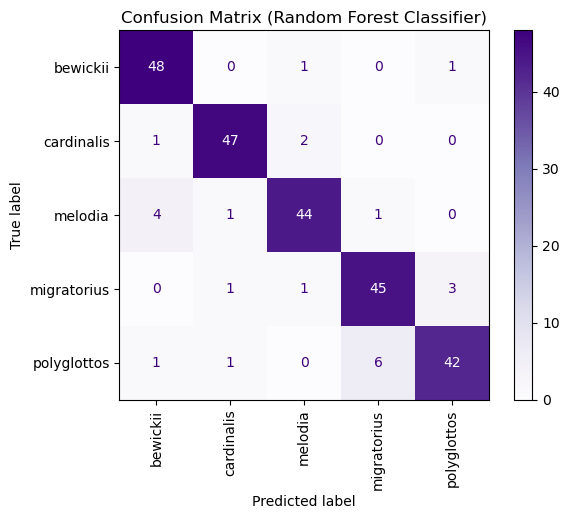

In [50]:
# Generate confusion matrix
rfc_confusion_matrix = confusion_matrix(Y_test, rfc_pred)
confusion_matrix_plot(rfc_confusion_matrix, 'Random Forest Classifier')

Precision Recall curve

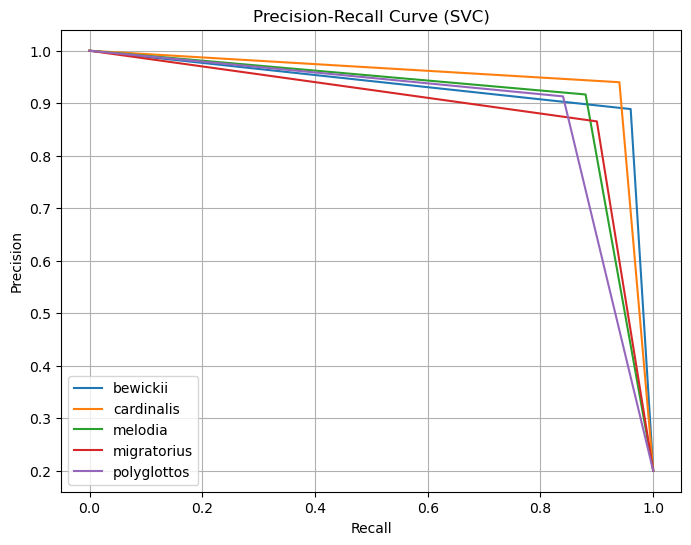

In [51]:
# Precision-recall curve for each bird species
Precision_Recall_Curve(rfc_pred, 'SVC')

#1D CNN

In [52]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [53]:
import tensorflow as tf

#Build 1D CNN model

In [54]:
def build_1d_model(audio_features):
    
    num_classes = 5
    
    tf.keras.backend.clear_session()
    
    # Audio features input layer
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')
    
    # First convolutional block
    x = tf.keras.layers.Conv1D(filters=35, kernel_size=5, name='conv_1', activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)

    # Second convolutional block
    x = tf.keras.layers.Conv1D(filters=70, kernel_size=5, name='conv_2', activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = tf.keras.layers.MaxPool1D(pool_size=3, name='pool_2')(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    
    # Flatten the output for feeding into the dense layers
    x = tf.keras.layers.Flatten()(x)

    # Dense layers with a dropout layer
    x = tf.keras.layers.Dense(units=500, name='dense_1', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Dense(units=100, name='dense_2', activation='relu')(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=num_classes, name='dense_3', activation='softmax')(x)
    
    # Build model and print summary
    model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')
    
    print(model.summary())
    
    # Compile model
    model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'],
              )

    return model

#Scale & Split data

with mfcc, bandwidth, spectral_centroid and rms

In [55]:
# Combine all features
features = np.concatenate((mfcc, bandwidth, spectral_centroid, rms), axis=2)

In [56]:
# calculate scalar mean and stantard deviation for cnn
data, mean_cnn, std_cnn = processed(features, mean=False) 

In [57]:
# Split the dataset ito features and target variable
X = data
Y = audio_labels['Encoded']

In [58]:
# Split the dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Split the train dataset to train and validation(val)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

In [59]:
print("Training set size:", len(x_train))
print("Test set size:", len(X_test))
print("val set size:", len(x_val))

print("Training set class distribution:", np.unique(y_train, return_counts=True))
print("val set class distribution:", np.unique(y_val, return_counts=True))
print("Test set class distribution:", np.unique(Y_test, return_counts=True))

Training set size: 1600
Test set size: 500
val set size: 400
Training set class distribution: (array([0, 1, 2, 3, 4], dtype=int64), array([320, 320, 320, 320, 320], dtype=int64))
val set class distribution: (array([0, 1, 2, 3, 4], dtype=int64), array([80, 80, 80, 80, 80], dtype=int64))
Test set class distribution: (array([0, 1, 2, 3, 4], dtype=int64), array([100, 100, 100, 100, 100], dtype=int64))


#Train the model

In [64]:
cnn_model = build_1d_model(x_train)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)     │ (None, 130, 23)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv1D)                 │ (None, 130, 35)        │         4,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 35)        │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling1D)           │ (None, 65, 35)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65, 35)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 65, 70)         │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling1D)           │ (None, 21, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1470)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       735,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802,625 (3.06 MB)

 Trainable params: 802,555 (3.06 MB)

 Non-trainable params: 70 (280.00 B)

None


tf.keras.utils.plot_model(cnn_model, dpi=70, show_layer_activations= True,
                          show_shapes=True)

In [65]:
history = cnn_model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2498 - loss: 3.4757 - val_accuracy: 0.5200 - val_loss: 2.4327
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5327 - loss: 2.2859 - val_accuracy: 0.6100 - val_loss: 2.0073
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6235 - loss: 1.8959 - val_accuracy: 0.6450 - val_loss: 1.7726
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6588 - loss: 1.6519 - val_accuracy: 0.6650 - val_loss: 1.5368
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7044 - loss: 1.4263 - val_accuracy: 0.6675 - val_loss: 1.3979
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7396 - loss: 1.2148 - val_accuracy: 0.7275 - val_loss: 1.2092
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7699 - loss: 1.0578 - val_accuracy: 0.6925 - val_loss: 1.1307
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7730 - loss: 1.0051 - val_accuracy: 0.7350 - v

Evaluation

In [66]:
# Evaluate the model on test data
test_loss, test_acc = cnn_model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {test_acc:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8400 - loss: 0.6875
Test Accuracy: 0.8500


#Loss and Accuracy plot

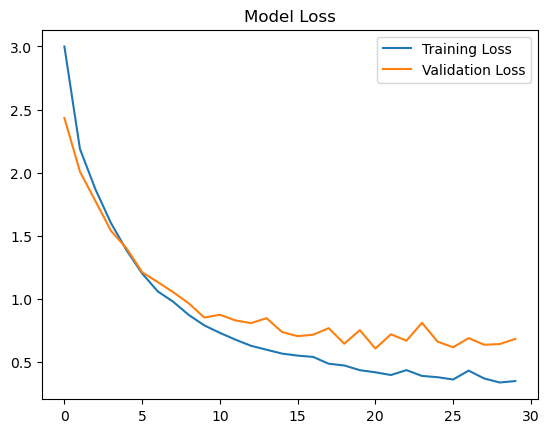

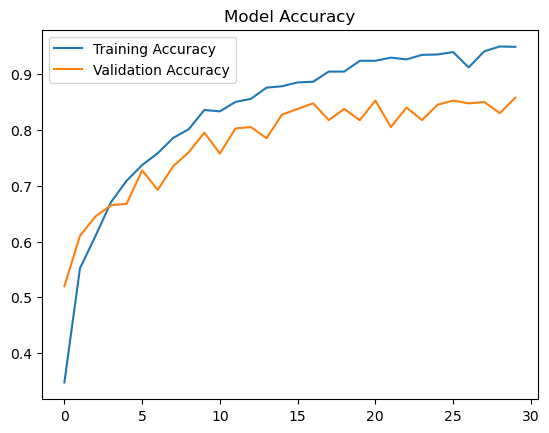

In [67]:
# Plot the training and validation loss/accuracy
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

classification report

In [68]:
# Generate classification report
cnn_pred = cnn_model.predict(X_test)
cnn_pred_classes = tf.math.argmax(cnn_pred, axis=1)  # Get predicted class labels

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [69]:
print(classification_report(Y_test, cnn_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

    bewickii       0.82      0.83      0.83       100
  cardinalis       0.89      0.90      0.90       100
     melodia       0.81      0.90      0.85       100
 migratorius       0.81      0.96      0.88       100
 polyglottos       0.97      0.66      0.79       100

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



confusion matrix

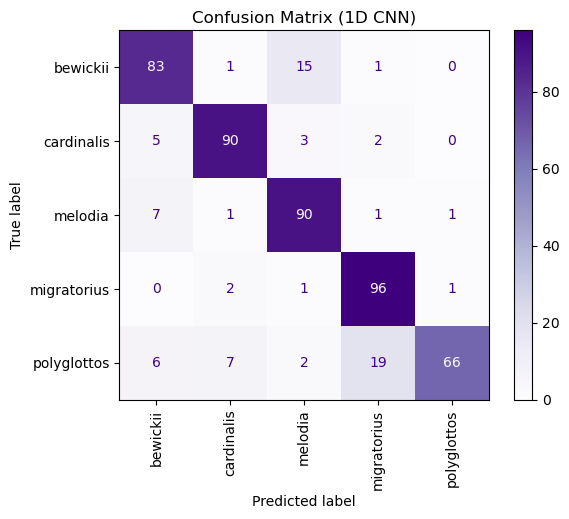

In [70]:
# Generate confusion matrix
cnn_confusion_matrix = confusion_matrix(Y_test, cnn_pred_classes)
confusion_matrix_plot(cnn_confusion_matrix, '1D CNN')

#Save Model

In [71]:
import pickle

In [72]:
# Models to save
models = ['KNN.pkl', 'SVC.pkl', 'Random Forest.pkl','1D_CNN.pkl']

# Location for saving the model (including model name and extension)
save_path = [f'/Users/91954/ my project/{model}' for model in models] 

for model, path in zip([knn, svc, rfc_model, cnn_model], save_path):
    with open(path, "wb") as f:# Open the file in binary write mode ('wb') for writing the pickled model
      pickle.dump(model, f)

print('Models saved successfully')

Models saved successfully


#Save scalar statistics

In [73]:
# save the precalculated scaling statistics mean and standard deviation for cnn model 
np.save('mean_cnn.npy', mean_cnn)
np.save('std_cnn.npy', std_cnn)

# save the precalculated scaling statistics mean and standard deviation for machine-learning model 
np.save('mean.npy', mean)
np.save('std.npy', std)